In [120]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [121]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=max(data)+(max(data)/data.shape[0]),
              cmap="RdYlBu", origin="lower", alpha=.75)


def padding(series, year):
    """
    Take pandas series, generate padding and return values as array
    """
    days_before = (min(series.index) - datetime(year,1,1)).days
    days_after = ((datetime(year,1,1) + timedelta(days=370)) - max(series.index)).days 
    pad_pre =  np.zeros(days_before)
    pad_post = np.zeros(days_after)

    return np.concatenate((pad_pre, series.values, pad_post))


datetime.datetime(2020, 1, 7, 0, 0)

In [119]:
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
a.reshape((6,2)).T

array([[ 1,  3,  5,  7,  9, 11],
       [ 2,  4,  6,  8, 10, 12]])

In [75]:
df = pd.read_csv('sgym_ship.csv', encoding = 'Shift-JIS')
df.columns = ['date','qty']
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()
df.head()

,qty
date,
2018-04-04,41296.0
2018-04-05,38153.0
2018-04-06,33987.0
2018-04-07,9665.0
2018-04-08,0.0


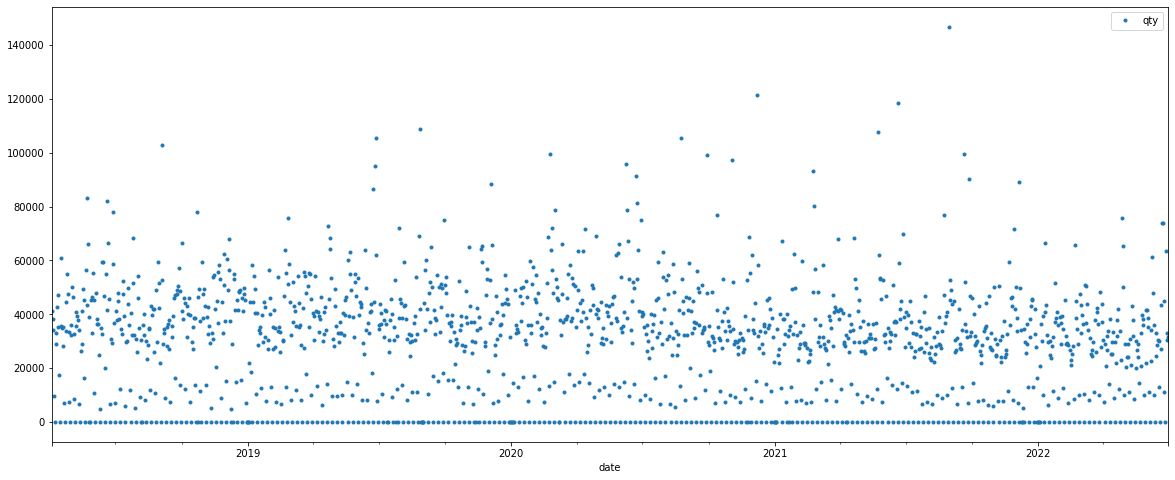

In [76]:
df.plot(style=".",figsize=(20,8), color=color_pal[0])

In [4]:
df.describe()

,qty
count,1549.000000
mean,30281.402195
std,20598.304323
min,0.000000
25%,12283.000000
50%,32534.000000
75%,42086.000000
max,146764.000000


# Analysis

In [116]:
def feature_crt(df):
    """
    Create date features using dataframe with date index
    """
    dow = ["Mon", "Tue", "Wed", "Thu","Fri","Sat","Sun"]

    df = df.copy()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    
    df["dow"] = df.index.dayofweek
    df["dow_text"] = df["dow"].apply(lambda x: dow[x])

    df["doy"] = df.index.dayofyear

    df["week"] = df.index.week
    df.loc[(df["month"]==12) & (df["week"]==1),["week"]] = 53
    df.loc[(df["month"]==1) & (df["week"]>=52),["week"]] = 0
    df["iswknd"] = df.dow.apply(lambda x: 1 if x> 5 else 0)
    df["ismidwk"] = df.dow.apply(lambda x: 1 if x in [2,3] else 0)
    # df["is_spring"] = df.month.apply(lambda x: 1 if x<4 else 0)
    # df["is_summer"] = df.month.apply(lambda x: 1 if x>=4 and x<7 else 0)
    # df["is_fall"] = df.month.apply(lambda x: 1 if x>=7 and x<10 else 0)
    # df["is_winter"] = df.month.apply(lambda x: 1 if x>=10 else 0)
    df["ssn"] = df.month.apply(lambda x: 1 if x<4 else 2 if x< 7 else 3 if x<10 else 4)
    df["last_one_third_of_month"] = df.day.apply(lambda x: 1 if x>=20 else 0)
    
    
    #CUSTOM CODE FOR ADDING HOLIDAYS AS FEATURE (SEEMED TO ACTUALLY MADE PREDICTION WORSE)
#     holidays = pd.read_csv("holidays.csv")
#     holidays["hld_flg"] = 1
#     holidays = holidays.drop("Year", axis=1).set_index("Date")
    
#     df = df.merge(holidays, how="left", left_index=True, right_index=True)
#     df["hld_flg"] = df["hld_flg"].fillna(0)

    return df
df_proc = feature_crt(df)

In [117]:
df_proc[df_proc.year==2019].head(10)

,qty,year,month,day,dow,dow_text,doy,week,iswknd,ismidwk,ssn,last_one_third_of_month
date,,,,,,,,,,,,
2019-01-01,0.0,2019,1,1,1,Tue,1,1,0,0,1,0
2019-01-02,0.0,2019,1,2,2,Wed,2,1,0,1,1,0
2019-01-03,21998.0,2019,1,3,3,Thu,3,1,0,1,1,0
2019-01-04,44416.0,2019,1,4,4,Fri,4,1,0,0,1,0
2019-01-05,18684.0,2019,1,5,5,Sat,5,1,0,0,1,0
2019-01-06,0.0,2019,1,6,6,Sun,6,1,1,0,1,0
2019-01-07,58452.0,2019,1,7,0,Mon,7,2,0,0,1,0
2019-01-08,44440.0,2019,1,8,1,Tue,8,2,0,0,1,0
2019-01-09,54063.0,2019,1,9,2,Wed,9,2,0,1,1,0


In [118]:
yr=2019
arr = padding(df_proc[df_proc.year == yr].qty,yr)

# fig, ax = plt.subplots(figsize=(20,7))
# calmap(ax,yr, arr.reshape((53,7)).T)


array([     0.,      0.,  21998.,  44416.,  18684.,      0.,  58452.,
        44440.,  54063.,  49240.,  40441.,  10352.,      0.,  40566.,
        28439.,  34034.,  35183.,  32885.,  12635.,      0.,  39559.,
        29707.,  44517.,  42525.,  31537.,   7683.,      0.,  30491.,
        27248.,  56485.,  46061.,  40115.,  12853.,      0.,  35410.,
        27202.,  41708.,  34853.,  27939.,   7508.,      0.,  53867.,
        33959.,  35198.,  33304.,  26128.,   6628.,      0.,  30623.,
        29898.,  46755.,  63793.,  55430.,  13063.,      0.,  75893.,
        51283.,  58841.,  44433.,  32302.,   8350.,      0.,  52095.,
        37163.,  43193.,  41279.,  35591.,  12058.,      0.,  54270.,
        35186.,  44243.,  36164.,  28505.,   8007.,      0.,  42469.,
        27305.,  55570.,  54053.,  47726.,  17874.,      0.,  50662.,
        35148.,  55361.,  55017.,  45709.,  10107.,      0.,  40646.,
        30631.,  39356.,  54052.,  41108.,  13414.,      0.,  40706.,
        33315.,  395

In [39]:
df_proc[(df_proc.year==2019) & (df_proc.month==6)]

,qty,year,month,day,dow,doy,week,iswknd,ismidwk,ssn,last_one_third_of_month
date,,,,,,,,,,,
2019-06-01,14275.0,2019,6,1,5,152,22,0,0,2,0
2019-06-02,0.0,2019,6,2,6,153,22,1,0,2,0
2019-06-03,53647.0,2019,6,3,0,154,23,0,0,2,0
2019-06-04,39714.0,2019,6,4,1,155,23,0,0,2,0
2019-06-05,44404.0,2019,6,5,2,156,23,0,1,2,0
2019-06-06,43678.0,2019,6,6,3,157,23,0,1,2,0
2019-06-07,42695.0,2019,6,7,4,158,23,0,0,2,0
2019-06-08,8301.0,2019,6,8,5,159,23,0,0,2,0
2019-06-09,0.0,2019,6,9,6,160,23,1,0,2,0


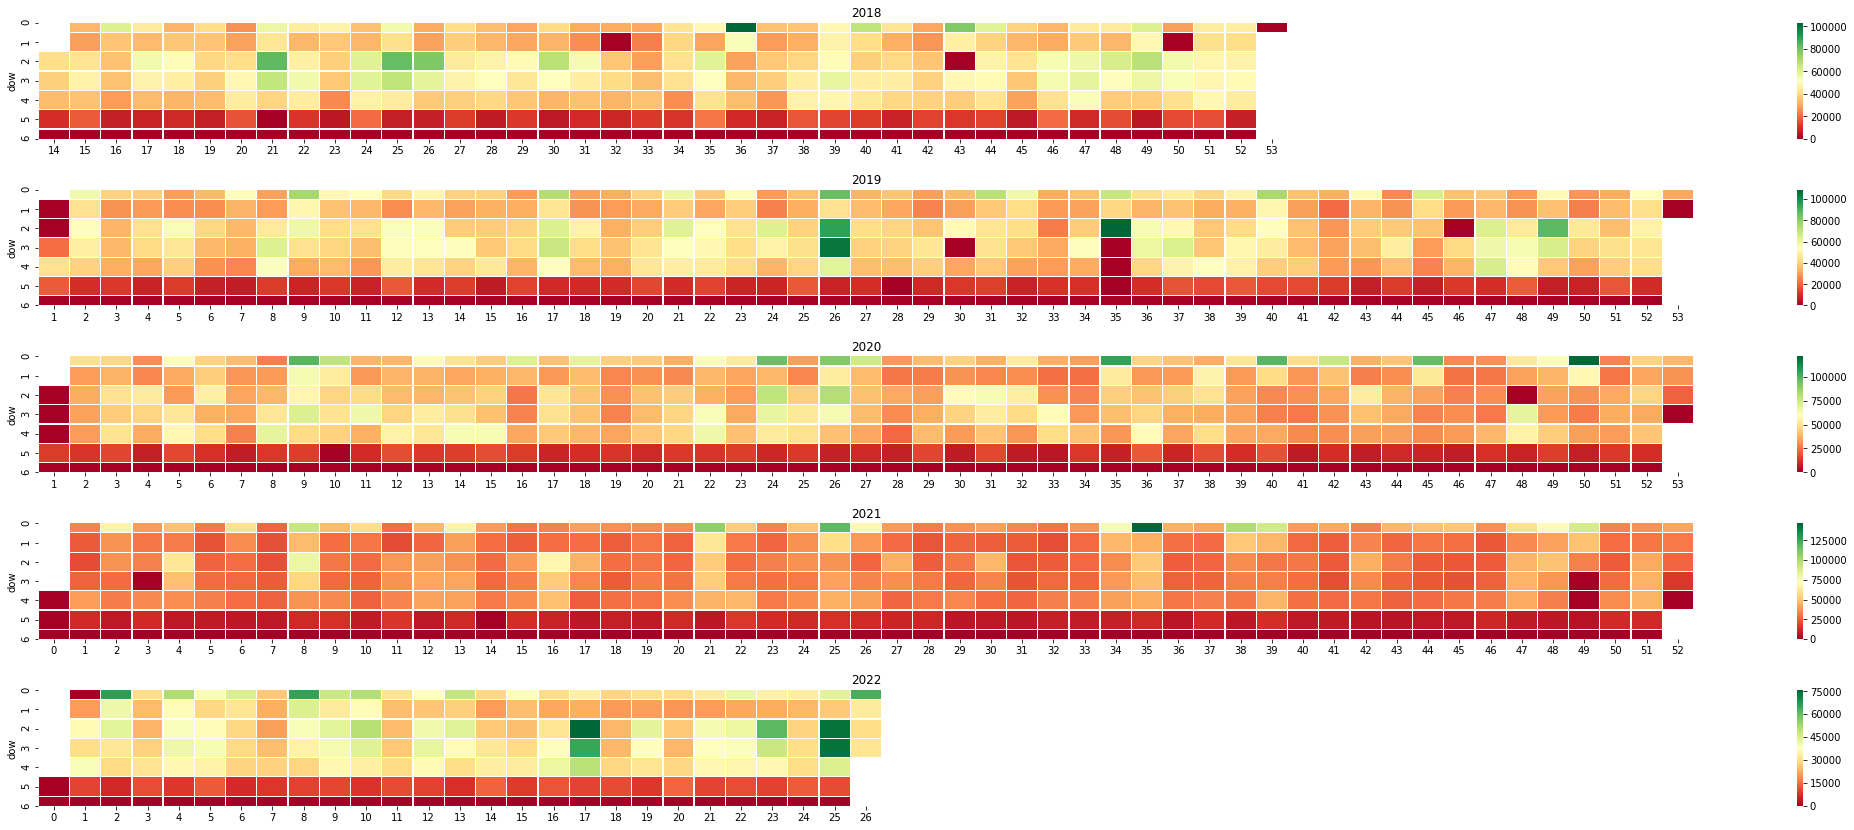

In [7]:
fig, axes = plt.subplots(5,1, figsize=(30,12))
fig.tight_layout(pad=3)
for idx, ax in enumerate(axes):
    df_heat = df_proc[df_proc.year==2018+idx].pivot(index="dow", columns="week", values="qty")
    sns.heatmap(df_heat,cmap='RdYlGn',linewidths=0.30,ax=ax)
    ax.set_title(f"{2018+idx}")
    ax.set_xlabel("")
    ax.set_xlim((0,53))
plt.show()

As can be seen from above, the clearest pattern is drop in sales on the weekend.   
Also, there is a slight increase in the middle of the month, as well as in summer.

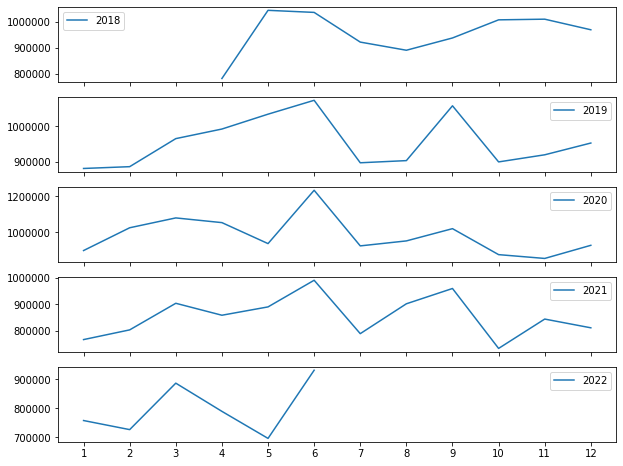

In [8]:
grouped = df_proc.groupby(["year","month"]).qty.sum()

fig, axes = plt.subplots(5,1,figsize=(10,8),sharex=True)

for ax, yr in zip(axes, df_proc["year"].unique()):
    ax.plot(grouped[yr], label=f"{yr}")
    ax.set_xticks(range(1,13))
    ax.set_xticklabels([i+1 for i in range(12)])
    ax.legend()

plt.show()

Looking at the above graph, we can see that there is a common pattern of a peak in March and June, followed by another uptick in September.

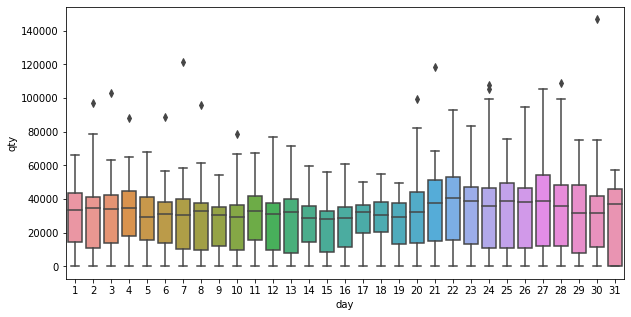

In [9]:
# group_by_day = df_proc.groupby("day").qty.mean()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, data=df_proc, x="day",y="qty")
plt.show()

There seems to be a pattern of higher demand at the end of the month

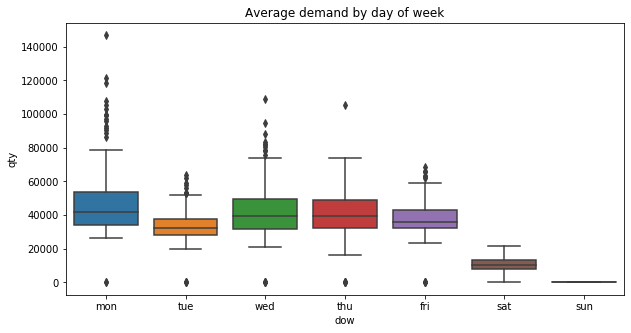

In [10]:
group_by_dow = df_proc.groupby("dow").qty.mean()

fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(group_by_dow, color=color_pal[2])
sns.boxplot(ax=ax, data=df_proc, x="dow",y="qty")
ax.set_xticks(range(7))
ax.set_xticklabels(["mon","tue","wed","thu","fri","sat","sun"])
ax.set_title("Average demand by day of week")
plt.show()

Looking at average demand by day of week, we see that demand is usually highest at week beginning and lower towards the weekend

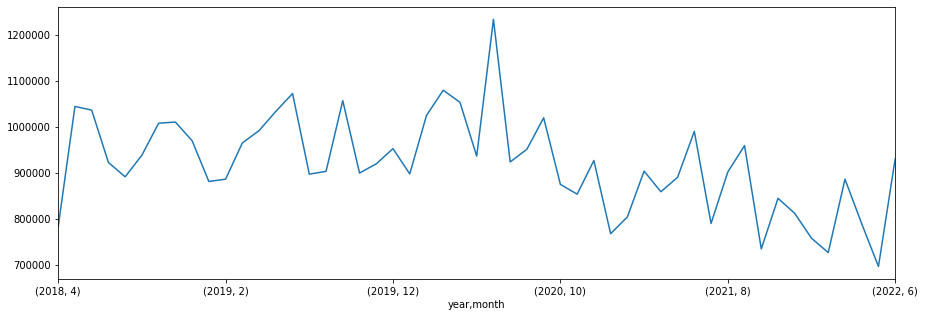

In [11]:
grouped.plot(figsize=(15,5))

# Train Test Split

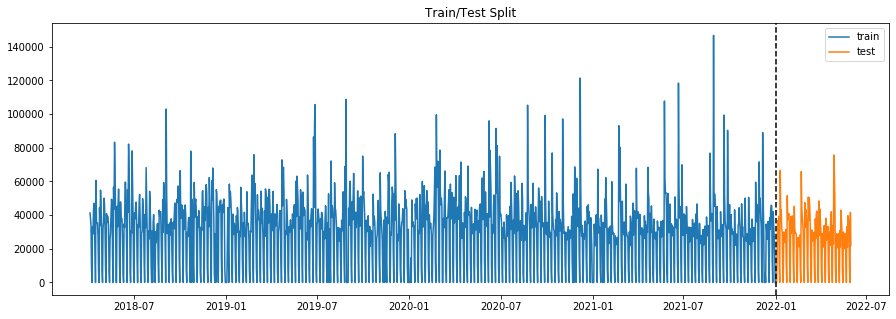

In [12]:
# Create train and test data, keeping 1 month of data for holdout
holdout_idx = "2022-06-01"
test_idx = "2022-01-01"
train = df.loc[df.index < test_idx]
test = df.loc[(df.index >= test_idx) & (df.index < holdout_idx)]
holdout = df.loc[df.index >= holdout_idx]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train, label="train")
ax.plot(test, label="test")
ax.axvline(pd.to_datetime(test_idx), color="black", ls="--")
ax.set_title("Train/Test Split")
plt.legend()
plt.show()

### Create features

In [112]:
def feature_crt(df):
    """
    Create date features using dataframe with date index
    """
    df = df.copy()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dow"] = df.index.dayofweek
    df["doy"] = df.index.dayofyear

    df["week"] = df.index.week
    df.loc[(df["month"]==12) & (df["week"]==1),["week"]] = 53
    df.loc[(df["month"]==1) & (df["week"]>=52),["week"]] = 0
    df["iswknd"] = df.dow.apply(lambda x: 1 if x> 5 else 0)
    df["ismidwk"] = df.dow.apply(lambda x: 1 if x in [2,3] else 0)
    # df["is_spring"] = df.month.apply(lambda x: 1 if x<4 else 0)
    # df["is_summer"] = df.month.apply(lambda x: 1 if x>=4 and x<7 else 0)
    # df["is_fall"] = df.month.apply(lambda x: 1 if x>=7 and x<10 else 0)
    # df["is_winter"] = df.month.apply(lambda x: 1 if x>=10 else 0)
    df["ssn"] = df.month.apply(lambda x: 1 if x<4 else 2 if x< 7 else 3 if x<10 else 4)
    df["last_one_third_of_month"] = df.day.apply(lambda x: 1 if x>=20 else 0)
    
    
    #CUSTOM CODE FOR ADDING HOLIDAYS AS FEATURE (SEEMED TO ACTUALLY MADE PREDICTION WORSE)
#     holidays = pd.read_csv("holidays.csv")
#     holidays["hld_flg"] = 1
#     holidays = holidays.drop("Year", axis=1).set_index("Date")
    
#     df = df.merge(holidays, how="left", left_index=True, right_index=True)
#     df["hld_flg"] = df["hld_flg"].fillna(0)

    return df

In [13]:
train = feature_crt(train)
test = feature_crt(test)

# excluded_features = ['qty', 'year', 'month', 'week','prediction']
# excluded_features = ["qty","week","is_summer"]
excluded_features = [col for col in train if col not in["dow","ismidwk","iswknd"]]
FEATURES = [col for col in train if col not in excluded_features]
TARGET = "qty"

In [14]:
FEATURES

['dow', 'iswknd', 'ismidwk']

In [15]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
holdout = feature_crt(holdout)
X_holdout = holdout[FEATURES]
y_holdout = holdout[TARGET]

# Model Creation

In [17]:
class XGBRegressorExtended(xgb.XGBRegressor):
    """
    Custom Regressor class for forecasting values
    """
    def predict_transform(self, xtest):
        yt = self.predict(xtest)
        yt[yt<0] = 0
        return yt

In [18]:
# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg = XGBRegressorExtended(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[15:11:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:36914.32812	validation_1-rmse:29974.79492
[100]	validation_0-rmse:17884.08398	validation_1-rmse:11002.56055
[200]	validation_0-rmse:13376.03516	validation_1-rmse:8710.51367
[300]	validation_0-rmse:12642.98047	validation_1-rmse:9579.84375
[400]	validation_0-rmse:12540.45898	validation_1-rmse:10100.80859
[500]	validation_0-rmse:12526.51660	validation_1-rmse:10314.77734
[600]	validation_0-rmse:12524.62793	validation_1-rmse:10396.27344
[700]	validation_0-rmse:12524.37207	validation_1-rmse:10426.62012
[800]	validation_0-rmse:12524

XGBRegressorExtended(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                     colsample_bynode=1, colsample_bytree=1,
                     early_stopping_rounds=50, enable_categorical=False,
                     gamma=0, gpu_id=-1, importance_type=None,
                     interaction_constraints='', learning_rate=0.01,
                     max_delta_step=0, max_depth=6, min_child_weight=1,
                     missing=nan, monotone_constraints='()', n_estimators=1000,
                     n_jobs=12, num_parallel_tree=1,
                     objective='reg:squarederror', predictor='auto',
                     random_state=0, reg_alpha=0, reg_lambda=1,
                     scale_pos_weight=1, subsample=1, tree_method='exact',
                     validate_parameters=1, verbosity=None)

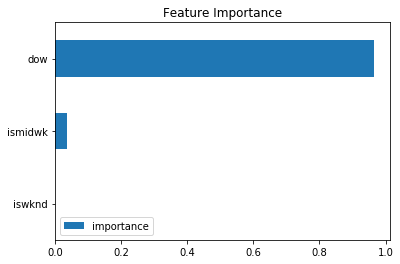

In [19]:
feat_imp = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
feat_imp.sort_values('importance').plot(kind='barh', title="Feature Importance")
plt.show()

# Predict on Test

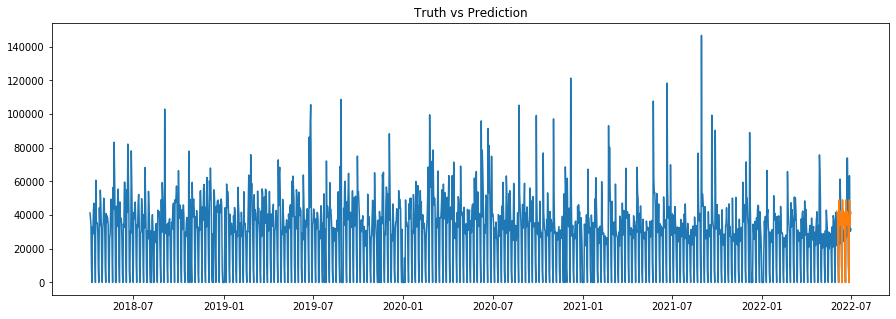

In [20]:
# test['prediction'] = reg.predict_transform(X_test)
holdout['prediction'] = reg.predict_transform(X_holdout)
# test['prediction'] = reg.predict(X_test)
if "prediction" in df_proc.columns:
    df_proc.drop("prediction", axis=1, inplace=True)
df_proc = df_proc.merge(holdout[['prediction']], how="left",left_index=True,right_index=True) #2 brackets -> dataframe instead of series

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_proc[["qty"]], label="Truth")
ax.plot(df_proc[["prediction"]],label="Prediction")
ax.set_title("Truth vs Prediction")
plt.show()

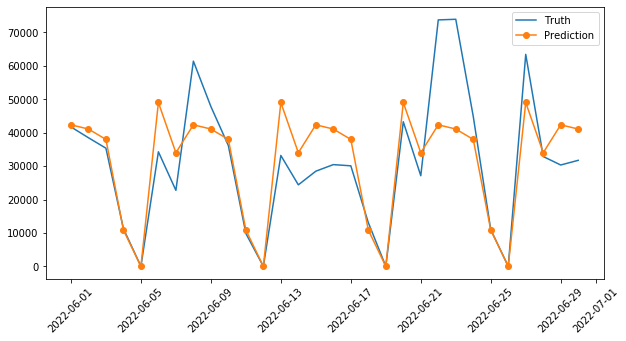

In [21]:
#Check for 1 month
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)].qty, label="Truth")
ax.plot(df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)].prediction,marker="o",label="Prediction")
plt.xticks(rotation=45)
ax.legend()
plt.show()

In [22]:
df_proc.loc[(df_proc["year"]==2022) & (df_proc["month"]==6)]

,qty,year,month,day,dow,doy,week,iswknd,ismidwk,ssn,last_one_third_of_month,prediction
date,,,,,,,,,,,,
2022-06-01,41729.0,2022,6,1,2,152,22,0,1,2,0,42359.640625
2022-06-02,38491.0,2022,6,2,3,153,22,0,1,2,0,41089.656250
2022-06-03,35358.0,2022,6,3,4,154,22,0,0,2,0,37990.394531
2022-06-04,11290.0,2022,6,4,5,155,22,0,0,2,0,10878.385742
2022-06-05,0.0,2022,6,5,6,156,22,1,0,2,0,0.000023
2022-06-06,34284.0,2022,6,6,0,157,23,0,0,2,0,49034.421875
2022-06-07,22747.0,2022,6,7,1,158,23,0,0,2,0,33996.035156
2022-06-08,61406.0,2022,6,8,2,159,23,0,1,2,0,42359.640625
2022-06-09,47837.0,2022,6,9,3,160,23,0,1,2,0,41089.656250


In [23]:
print(np.sqrt(mean_squared_error(holdout['qty'], holdout['prediction'])))
print(holdout["qty"].mean())

from sklearn.metrics import mean_absolute_error as mae
print(mae(holdout["qty"], holdout["prediction"]) / holdout["qty"].mean())


11720.097006514117
31037.2
0.2597338021460631


# Create Lag Feature

In [24]:
# How to create lag features
# Decide lag: 28 days
# Get lagged date and lagged values
# Below is the naive way. There is a better way using Series.map below
# df_lagged = df.copy()
# df_lagged.index = df.index + pd.Timedelta(days=28)
# df_lagged.rename(columns={"qty":"lag_28_d"}, inplace=True)
# df.merge(df_lagged, how="left", left_index=True, right_index=True)

In [25]:
def lag_features(df, val_col: str = "qty", lag_period: int = 1, multiplier: int = 28):
    """
    Return df with lag features added
    lag_period: lag period in days
    multiplier: specify number of lag features to be created, which will be a multiplier of the lag_period.
    """
    df_lagged = df.copy()
    for i in range(lag_period, lag_period*(multiplier+1), lag_period):
        if f"lag{i}d" in df_lagged.columns:
            df_lagged.drop(f"lag{i}d", axis=1, inplace=True)
        df_lagged[f"lag{i}d"] = (df.index - pd.Timedelta(f"{i} days")).map(df[val_col])
    
    return df_lagged


In [26]:
df = lag_features(df, "qty")
df.head()

,qty,lag1d,lag2d,lag3d,lag4d,lag5d,lag6d,lag7d,lag8d,lag9d,...,lag19d,lag20d,lag21d,lag22d,lag23d,lag24d,lag25d,lag26d,lag27d,lag28d
date,,,,,,,,,,,,,,,,,,,,,
2018-04-04,41296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-05,38153.0,41296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-06,33987.0,38153.0,41296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-07,9665.0,33987.0,38153.0,41296.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-08,0.0,9665.0,33987.0,38153.0,41296.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Test with cross validation


In [27]:
def ts_split(df_input, holdout_idx, fold, gap):
    
    df = df_input[df_input.index < holdout_idx]
    max_idx = len(df.index)-1
    train_idx = [idx for idx in df.index if idx < df.index[max_idx-gap*(fold+1)]]
    val_idx = [idx for idx in df.index if idx >= df.index[max_idx-gap*(fold+1)] and idx <= df.index[max_idx-gap*fold]]
    
    return train_idx, val_idx


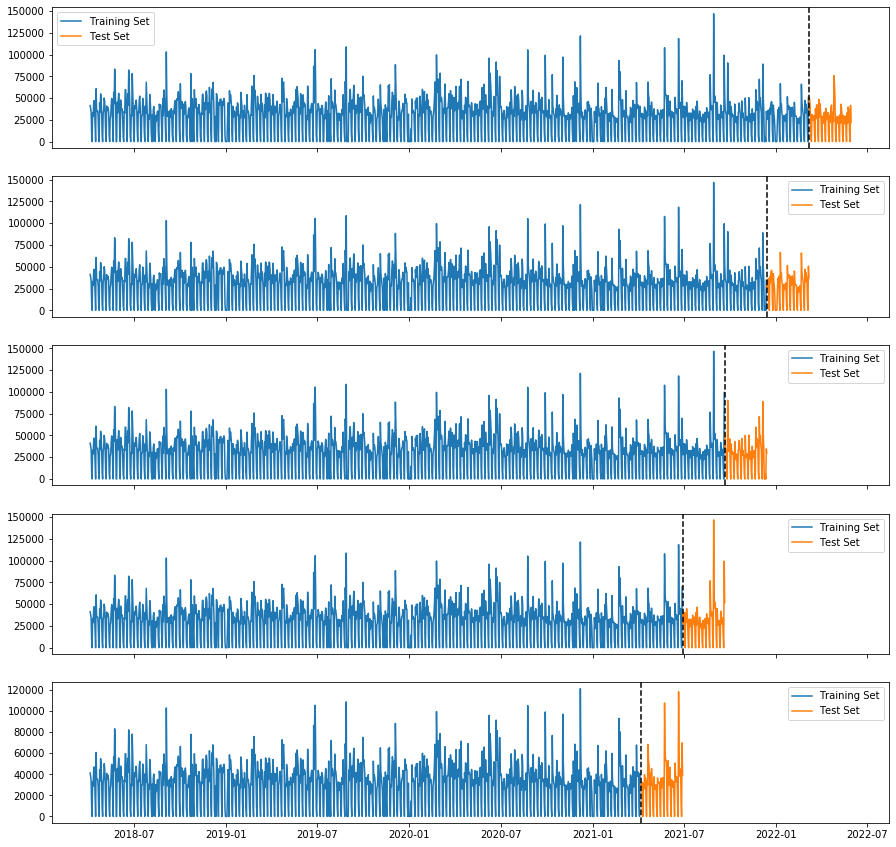

In [28]:
fig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True)
for fold in range(5):
    train_idx, val_idx = ts_split(df, holdout_idx, fold, gap=84)
    train = df.loc[train_idx]
    test = df.loc[val_idx]
    axes[fold].plot(train["qty"], label="Training Set")
    axes[fold].plot(test["qty"], label="Test Set")
    axes[fold].axvline(test.index.min(), color="black", ls="--")
    axes[fold].legend()

plt.show()

In [29]:
holdout = df.loc[df.index >= holdout_idx]
holdout = feature_crt(holdout)

preds = []
scores_rmse = []
scores_mae = []
for fold in range(5):
    train_idx, val_idx = ts_split(df, holdout_idx, fold, gap=84)
    train_cv = df.loc[train_idx]
    test_cv = df.loc[val_idx]
    train_cv = feature_crt(train_cv)
    test_cv = feature_crt(test_cv)

    FEATURES = [col for col in train_cv.columns if col not in excluded_features]
    TARGET = "qty"
    print(FEATURES)
    
    X_train_cv = train_cv[FEATURES]
    y_train_cv = train_cv[TARGET]
    X_test_cv = test_cv[FEATURES]
    y_test_cv = test_cv[TARGET]
    X_holdout = holdout[FEATURES]
    y_holdout = holdout[TARGET]
    
    
    reg_cv = XGBRegressorExtended(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
    reg_cv.fit(X_train_cv, y_train_cv, 
           eval_set=[(X_train_cv, y_train_cv), (X_test_cv, y_test_cv)],
           verbose=100)
    y_pred = reg_cv.predict_transform(X_holdout)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
    scores_rmse.append(score_rmse)
    score_mae = mae(y_holdout, y_pred)
    scores_mae.append(score_mae)

['lag1d', 'lag2d', 'lag3d', 'lag4d', 'lag5d', 'lag6d', 'lag7d', 'lag8d', 'lag9d', 'lag10d', 'lag11d', 'lag12d', 'lag13d', 'lag14d', 'lag15d', 'lag16d', 'lag17d', 'lag18d', 'lag19d', 'lag20d', 'lag21d', 'lag22d', 'lag23d', 'lag24d', 'lag25d', 'lag26d', 'lag27d', 'lag28d', 'dow', 'iswknd', 'ismidwk']
[15:11:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:36637.90234	validation_1-rmse:29508.92969
[100]	validation_0-rmse:15917.94922	validation_1-rmse:11958.83789
[200]	validation_0-rmse:9105.14356	validation_1-rmse:9160.46582
[300]	validation_0-rmse:6940.29639	validation_1-rmse:9318.5

In [30]:
scores_rmse

[12784.760889292858,
 12864.804689324914,
 12497.800437852156,
 12066.625901070134,
 12075.951833584104]

In [31]:
[x / holdout["qty"].mean() for x in scores_mae]

[0.25916996042920537,
 0.26706850924529635,
 0.2645238359861878,
 0.257470644332721,
 0.2562831649579361]

In [32]:
FEATURES

['lag1d',
 'lag2d',
 'lag3d',
 'lag4d',
 'lag5d',
 'lag6d',
 'lag7d',
 'lag8d',
 'lag9d',
 'lag10d',
 'lag11d',
 'lag12d',
 'lag13d',
 'lag14d',
 'lag15d',
 'lag16d',
 'lag17d',
 'lag18d',
 'lag19d',
 'lag20d',
 'lag21d',
 'lag22d',
 'lag23d',
 'lag24d',
 'lag25d',
 'lag26d',
 'lag27d',
 'lag28d',
 'dow',
 'iswknd',
 'ismidwk']

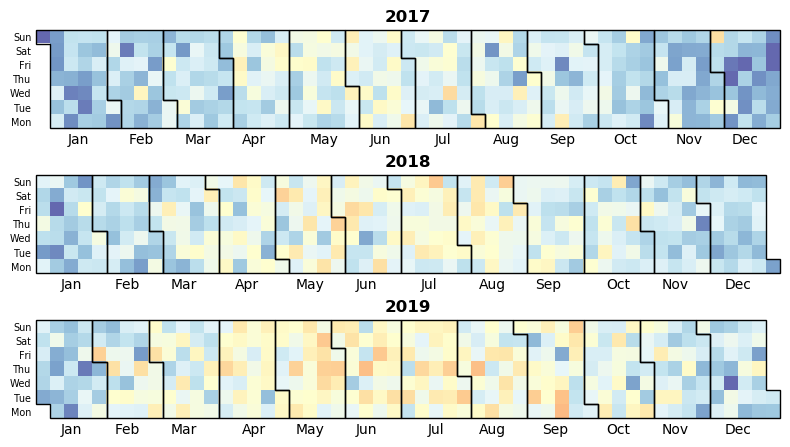